In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install timm

In [4]:
from pathlib import Path

from fastai.vision.all import *
import pandas as pd
import numpy as np
import timm
from pathlib import Path

BASE_DIR   = Path('/content/drive/MyDrive/Music_Genre_Classification')
DATA_SPEC  = BASE_DIR / 'data_spectrograms_v2'
MODELS_DIR = BASE_DIR / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)

DATA_SPEC, MODELS_DIR


(Path('/content/drive/MyDrive/Music_Genre_Classification/data_spectrograms_v2'),
 Path('/content/drive/MyDrive/Music_Genre_Classification/models'))

In [5]:
# Root has: train/, valid/, test/
root = DATA_SPEC
train_valid_root = root  # GrandparentSplitter will select train/valid
genres = sorted([d.name for d in (root/'train').iterdir() if d.is_dir()])
genres


['Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Pop',
 'Rock']

In [6]:
from fastai.vision.all import *
import random

class SpecAugment(RandTransform):
    split_idx = 0
    "Simple SpecAugment-like masking on spectrogram images."
    def __init__(
        self,
        time_mask_frac=0.15,
        freq_mask_frac=0.15,
        n_time_masks=2,
        n_freq_masks=2,
        p=0.7,
        **kwargs
    ):
        super().__init__(p=p, **kwargs)
        self.time_mask_frac = time_mask_frac
        self.freq_mask_frac = freq_mask_frac
        self.n_time_masks = n_time_masks
        self.n_freq_masks = n_freq_masks

    def _apply_to_single(self, x:TensorImage):
        "Apply time/freq masks to a single image of shape (C,H,W)."
        c, h, w = x.shape

        # Frequency masks (horizontal bands)
        for _ in range(self.n_freq_masks):
            mask_height = int(self.freq_mask_frac * h)
            if mask_height < 1:
                continue
            f0 = random.randint(0, max(0, h - mask_height))
            x[:, f0:f0+mask_height, :] = 0.

        # Time masks (vertical bands)
        for _ in range(self.n_time_masks):
            mask_width = int(self.time_mask_frac * w)
            if mask_width < 1:
                continue
            t0 = random.randint(0, max(0, w - mask_width))
            x[:, :, t0:t0+mask_width] = 0.

        return x

    def encodes(self, x:TensorImage):
        # x can be (C,H,W) or (B,C,H,W)
        if x.ndim == 3:
            return self._apply_to_single(x)
        elif x.ndim == 4:
            # apply to each item in the batch
            for i in range(x.shape[0]):
                x[i] = self._apply_to_single(x[i])
            return x
        else:
            return x


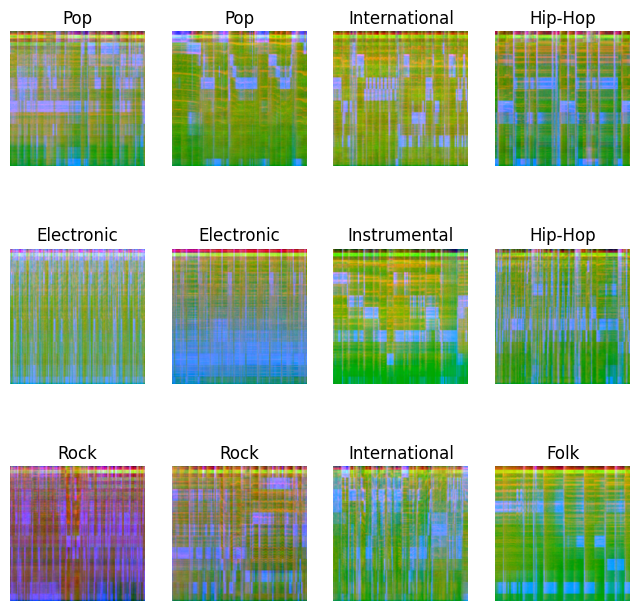

In [7]:
# DataBlock: images of spectrograms, labels = parent folder (genre)
root = DATA_SPEC

music_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=[
        SpecAugment(
          time_mask_frac=0.08,
          freq_mask_frac=0.08,
          n_time_masks=1,
          n_freq_masks=1,
          p=0.5
        ),
        Normalize.from_stats(*imagenet_stats),
    ]
)

dls = music_block.dataloaders(root, bs=32)  # maybe 32 now, to be safe
dls.show_batch(max_n=12, figsize=(8, 8))



In [8]:
len(dls.train_ds), len(dls.valid_ds), dls.c, dls.vocab


(24726,
 5291,
 8,
 ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock'])

In [9]:
from collections import Counter
from fastai.vision.all import *

train_files = get_image_files(DATA_SPEC/'train')
train_labels = [f.parent.name for f in train_files]
Counter(train_labels)


Counter({'Electronic': 3098,
         'Experimental': 3095,
         'Folk': 3094,
         'Hip-Hop': 3076,
         'Instrumental': 3070,
         'International': 3100,
         'Pop': 3103,
         'Rock': 3090})

In [10]:
learn = vision_learner(
    dls,
    'efficientnet_b2',
    metrics=accuracy,
    pretrained=True
)
learn



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

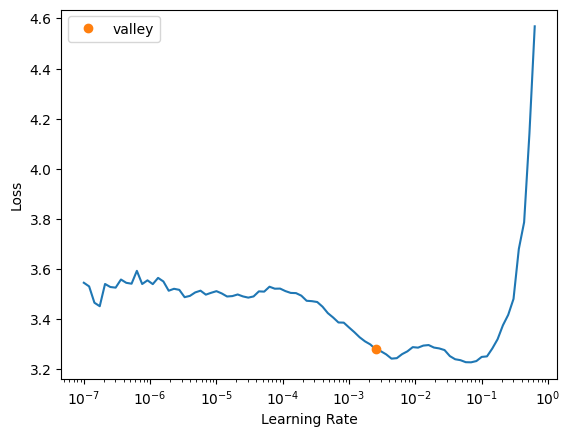

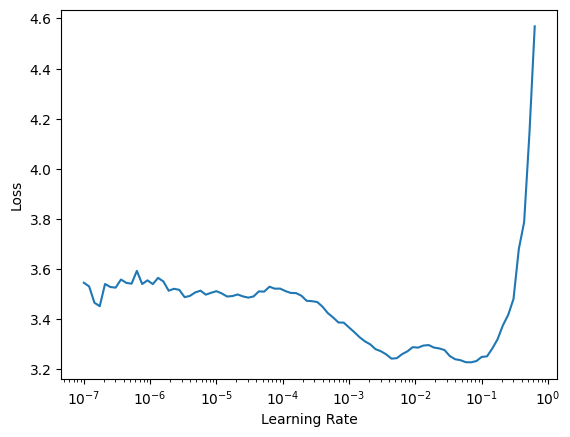

In [9]:
lr = learn.lr_find()
lr
learn.recorder.plot_lr_find()

In [11]:
lr = 1e-3  # if lr_min is None, just use 1e-3

learn.fine_tune(
    20,               # start with 10 epochs; you can increase later
    base_lr=lr
)


epoch,train_loss,valid_loss,accuracy,time
0,1.952201,1.711960,0.403893,29:24


epoch,train_loss,valid_loss,accuracy,time
0,1.700520,1.556527,0.450387,01:31
1,1.627966,1.519163,0.460782,01:30
2,1.545607,1.498092,0.469098,01:31
3,1.527144,1.472351,0.473067,01:31
4,1.444392,1.447853,0.485541,01:32
5,1.434099,1.422111,0.487620,01:31
6,1.383799,1.399122,0.507465,01:32
7,1.332339,1.387028,0.516726,01:32
8,1.295884,1.370464,0.516916,01:32
9,1.290820,1.351724,0.529768,01:32


In [12]:
val_loss, val_acc = learn.validate()
val_loss, val_acc

(1.3282320499420166, 0.5407295227050781)

[('Pop', 'Rock', np.int64(108)),
 ('Hip-Hop', 'Electronic', np.int64(107)),
 ('Pop', 'Folk', np.int64(102)),
 ('Pop', 'Electronic', np.int64(95)),
 ('Experimental', 'Electronic', np.int64(88)),
 ('Experimental', 'Instrumental', np.int64(88)),
 ('Rock', 'Pop', np.int64(86)),
 ('Pop', 'International', np.int64(72)),
 ('Instrumental', 'Experimental', np.int64(68)),
 ('International', 'Folk', np.int64(65)),
 ('Folk', 'Instrumental', np.int64(63)),
 ('Pop', 'Instrumental', np.int64(62)),
 ('Instrumental', 'Folk', np.int64(60)),
 ('Rock', 'Folk', np.int64(58)),
 ('Folk', 'International', np.int64(54)),
 ('Rock', 'Experimental', np.int64(53)),
 ('International', 'Electronic', np.int64(52)),
 ('Hip-Hop', 'International', np.int64(51)),
 ('Experimental', 'Folk', np.int64(49)),
 ('Folk', 'Pop', np.int64(48)),
 ('Instrumental', 'Rock', np.int64(47)),
 ('International', 'Hip-Hop', np.int64(47)),
 ('Experimental', 'Pop', np.int64(45)),
 ('Instrumental', 'Electronic', np.int64(45)),
 ('Pop', 'Experi

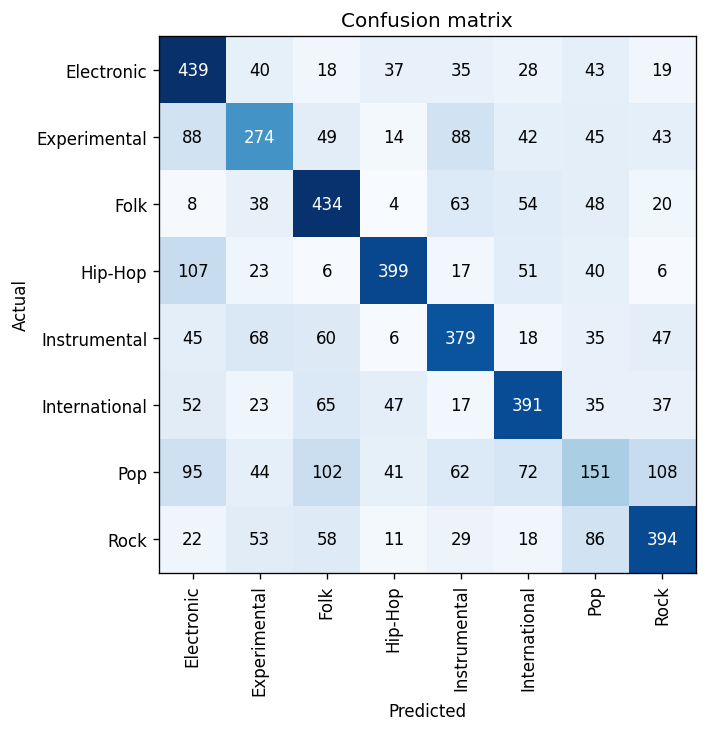

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6, 6), dpi=120)
interp.most_confused(min_val=10)

In [14]:
test_files = get_image_files(root/'test')
len(test_files), test_files[0]


(5309,
 Path('/content/drive/MyDrive/Music_Genre_Classification/data_spectrograms_v2/test/Electronic/092549_chunk00.png'))

In [15]:
test_dl = dls.test_dl(test_files)
preds, _ = learn.get_preds(dl=test_dl)
preds.shape

torch.Size([5309, 8])

In [16]:
# True labels (as indices matching dls.vocab)
test_labels = np.array([dls.vocab.o2i[f.parent.name] for f in test_files])
test_preds = preds.argmax(dim=1).numpy()

test_acc = (test_preds == test_labels).mean()
test_acc

np.float64(0.561499340742136)

In [17]:
learn.save(MODELS_DIR / 'effnet_b2_fma_small_v2')

# Full export (includes architecture + preprocessing)
learn.export(MODELS_DIR / 'effnet_b2_fma_small_v2_export.pkl')
MODELS_DIR

Path('/content/drive/MyDrive/Music_Genre_Classification/models')